In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from PIL import Image
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import label_map_util

warnings.filterwarnings('ignore')

In [2]:
label_path = os.path.join("my_model_v2", "label_map.pbtxt")
model_path = os.path.join("my_model_v2", "saved_model")

In [3]:
model = tf.saved_model.load(str(model_path))
model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x2cedb9070>

In [4]:
def create_category_index(label_path):
    category_index = label_map_util.create_categories_from_labelmap(str(label_path), use_display_name=True)
    cat_dict = {}
    for i, cat in enumerate(category_index):
        cat_dict[i+ 1] = cat
    return cat_dict

In [6]:
category_index = create_category_index(label_path)
category_index

{1: {'id': 1, 'name': 'alpha-romeo'},
 2: {'id': 2, 'name': 'bwt'},
 3: {'id': 3, 'name': 'ferrari'},
 4: {'id': 4, 'name': 'haas'},
 5: {'id': 5, 'name': 'mclaren'},
 6: {'id': 6, 'name': 'mercedes'},
 7: {'id': 7, 'name': 'red-bull'},
 8: {'id': 8, 'name': 'renault'},
 9: {'id': 9, 'name': 'toro-rosso'},
 10: {'id': 10, 'name': 'williams'}}

In [7]:
def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

In [8]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    input_tensor = tf.convert_to_tensor(image)
    input_tensor = input_tensor[tf.newaxis,...]
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
    
    output_dict['num_detections'] = num_detections
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
    if 'detection_masks' in output_dict:
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
    return output_dict

In [24]:
def show_inference(model, image_path):
    image_np = np.array(Image.open(image_path))
    output_dict = run_inference_for_single_image(model, image_np)
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=2,
        max_boxes_to_draw=5,
        min_score_thresh=0.05)

    display(Image.fromarray(image_np))

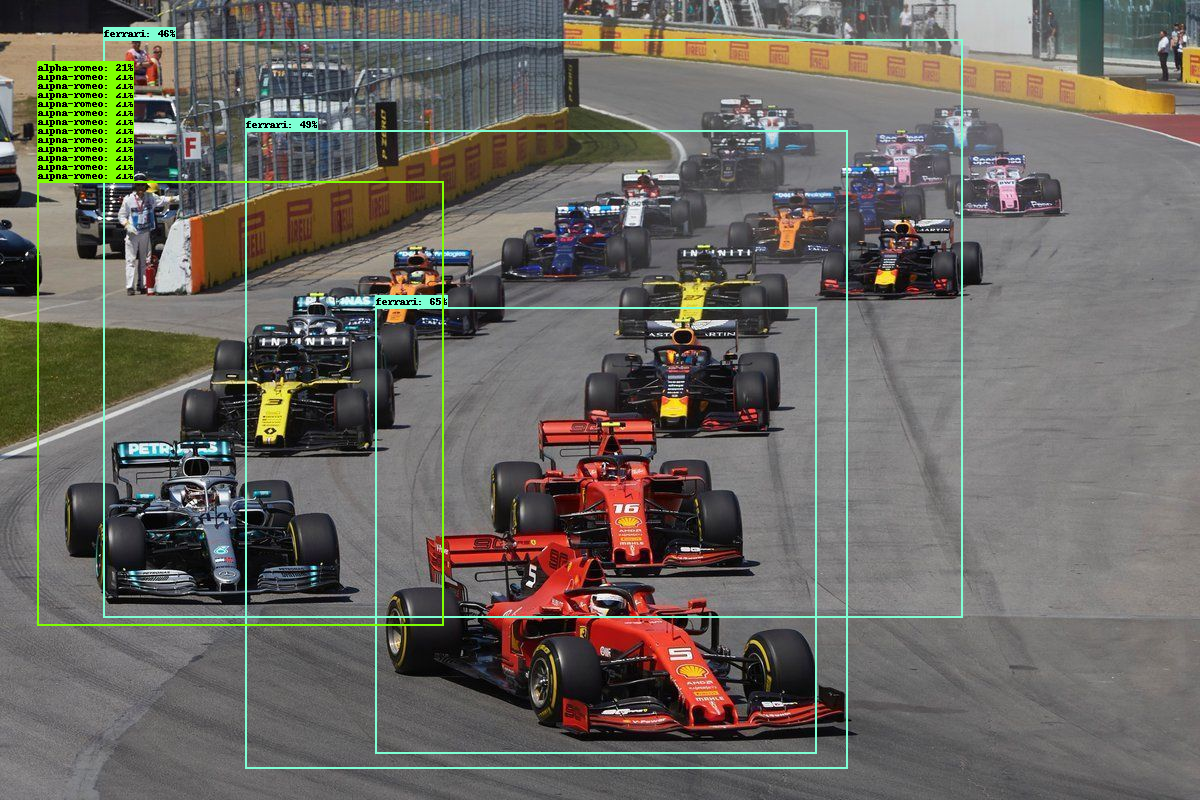

In [25]:
image_path = os.path.join("images_v2", "teams.jpg")
show_inference(model, image_path)